## Association Rule Learning Homework

*Prepared by:*
**Jude Michael Teves**  
Faculty, Software Technology Department  
College of Computer Studies - De La Salle University

---

Submitted by:
- Guerra, Jose Maria Angelo
- Hinolan, Charles Joseph
- Lasala, Kyle Carlo
- Lorenzo, Antonio Jose Maria
- Roco, Katrina Bianca

## Requirements

Answer the following questions:

**Groceries Dataset**  
1. Calculate the association rules and find the `significant/interesting` items in this dataset. Feel free to use any threshold value. (10 pts)
    - group the items by member
    - group the items by month
2. What would you recommend to the owner of a grocery store given these association rules? (15 pts)
3. Is there any other grouping that could give us high confidence/interest? (10 pts)

**Another Dataset**  
1. Find another dataset that can be turned into an association rule learning problem. Ideally, more than 1000 transactions/records. This does not have to be grocery-related. (20 pts)
2. Similar to the grocery dataset, calculate the association rules and find the `significant/interesting` items. (10 pts)
3. What would you recommend given the association rules? (25 pts)
4. Any other learning?

Note:
 - You have to create a writeup on the code you've written. Make sure that the code is clean as well. (5 pts)
 - Cite references if there are any. If you will be using the code I've given, cite it. If you got help from your peers, cite it as well. (5 pts)
 - Submit the link for your copy of this Google Colaboratory notebook. **Make sure it's public**. You may use incognito to see if the link is accessible.

<hr>

## Grading Criteria

|Criteria|Points|
|---|---|
|Groceries Dataset Analysis|35|
|Another Dataset Analysis|55|
|Code Cleanliness|5|
|References|5|


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from fim import arules, apriori, fpgrowth

# Spotify Dataset

Spotify Tracks Dataset from https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

## Preliminaries

In [26]:
#path = r"C:\Users\bianc\Desktop\AssocRuleLearning\dataset.csv"
path = r"dataset.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [27]:
df.dtypes

,0
track_id,object
artists,object
album_name,object
track_name,object
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64
key,int64


## Data Preprocessing

### Dropping Null Values

In [28]:
df.isnull().sum()

,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0
key,0


In [29]:
df = df.dropna()

### Removing Duplicates

In [30]:
print(df['track_id'].duplicated().sum())

24259


In [31]:
df['track_id'].value_counts().head(10)


,count
track_id,
6S3JlDAGk3uu3NtZbPnuhS,9
2Ey6v4Sekh3Z0RUSISRosD,8
2kkvB3RNRzwjFdGhaUA0tz,8
08kTa3SL9sV6Iy8KLKtGql,7
4XYieGKSlJlHpzB3bl6WMP,7
5ZsAhuQ24mWHiduaxJqnhW,7
0YLSjVxSb5FT1Bo8Tnxr8j,7
4WJTKbNJQ41zXnb84jSWaj,7
2aaClnypAakdAmLw74JXxB,7


retain the most popular version of each song

In [32]:
df = df.sort_values(by='popularity', ascending=False).drop_duplicates(subset='track_id').reset_index(drop=True)
print(df['track_id'].duplicated().sum())

0


### Preprocessing Int Columns

In [33]:
int_cols = df.select_dtypes(include=['int64']).columns
int_cols

Index(['popularity', 'duration_ms', 'key', 'mode', 'time_signature'], dtype='object')

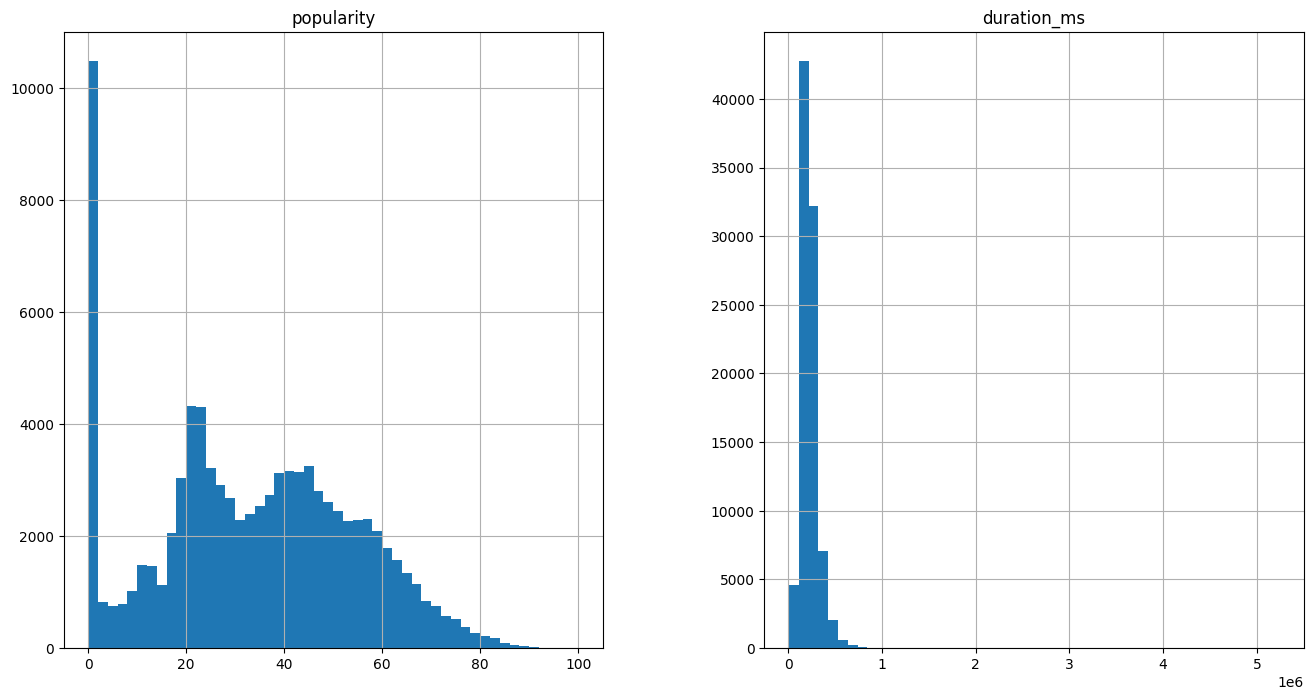

In [34]:
int_cols = ['popularity','duration_ms']
df[int_cols].hist(figsize=(16, 8),bins=50)
plt.show()

#### Binning

In [35]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bin = []
five_bin = []

for x in int_cols:
    range = df[x].max() - df[x].min()
    std = df[x].std()
    if range < 3 * std:
        three_bin.append(x)
    else:
        five_bin.append(x)

print("Columns with 3 bins:", three_bin)
print("Columns with 5 bins:", five_bin)

Columns with 3 bins: []
Columns with 5 bins: ['popularity', 'duration_ms']


In [36]:
labels_3 = ['Low', 'Medium', 'High']
labels_5 = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_bins = df[['track_id']].copy()

for col in three_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=3, labels=labels_3)

for col in five_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=5, labels=labels_5)

df_bins_int = df_bins
df_bins

,track_id,popularity_bin,duration_ms_bin
0,3nqQXoyQOWXiESFLlDF1hG,Very High,Very Low
1,2tTmW7RDtMQtBk7m2rYeSw,Very High,Very Low
2,5ww2BF9slyYgNOk37BlC4u,Very High,Very Low
3,4uUG5RXrOk84mYEfFvj3cK,Very High,Very Low
4,1IHWl5LamUGEuP4ozKQSXZ,Very High,Very Low
...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Very Low,Very Low
89736,4WCpgL2vHyx2vusJ5mbBnF,Very Low,Very Low
89737,5FImqqYMK6ZwLwClPDds8c,Very Low,Very Low
89738,4BsasVXlffiJ69bRrJXWZO,Very Low,Very Low


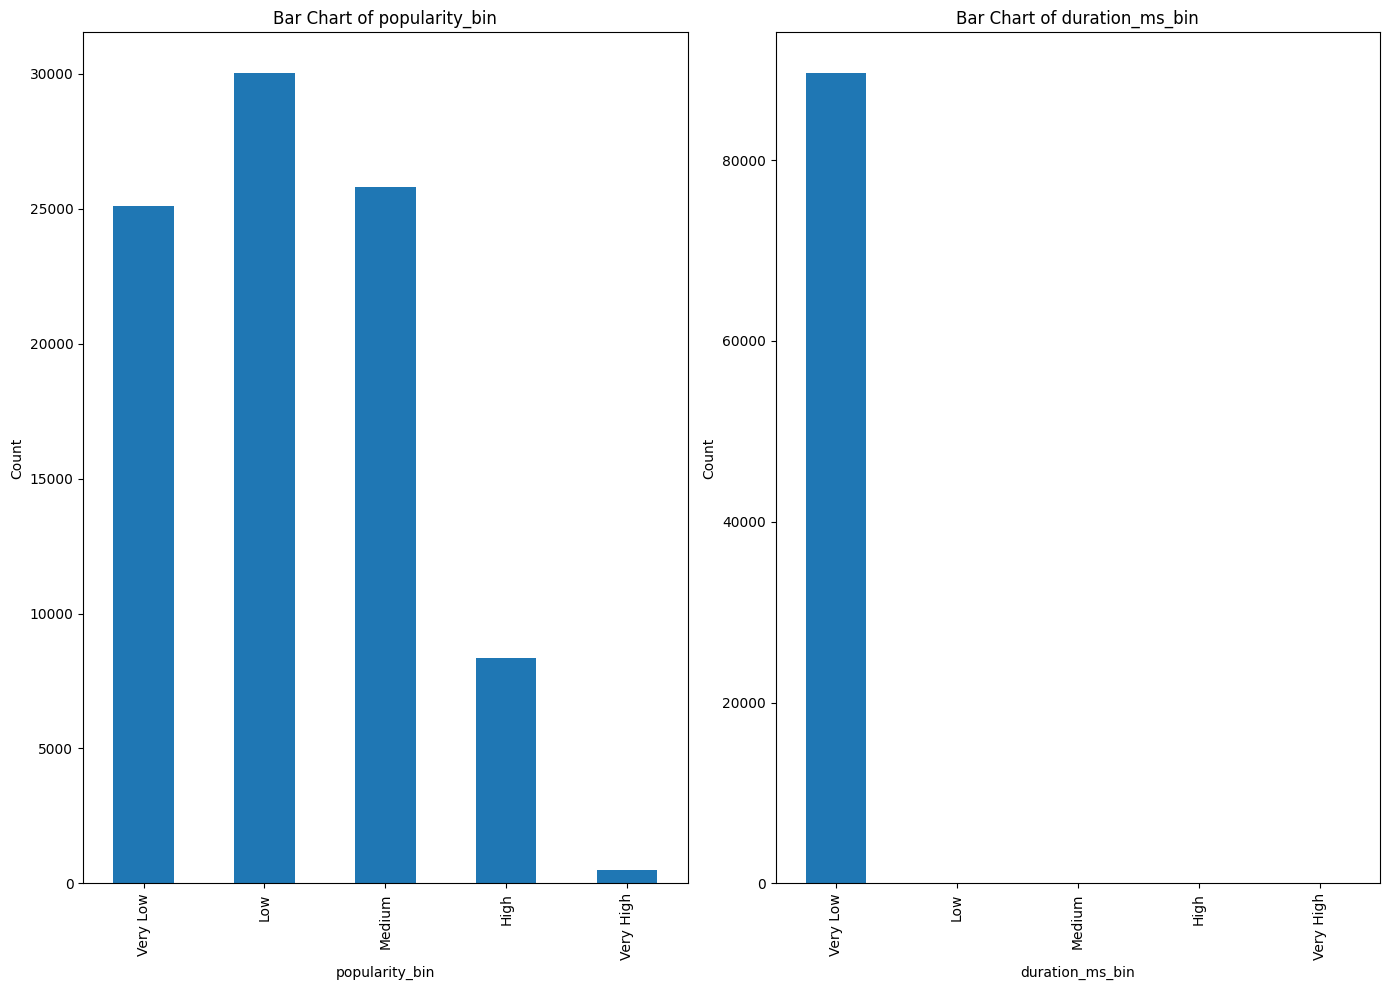

In [37]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(1,2,figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()

In [38]:
df_int_encoded = pd.get_dummies(df_bins[binned_cols])
df_int_encoded = pd.concat([df_bins[['track_id']], df_int_encoded], axis=1)
df_int_encoded

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,duration_ms_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,False


### Preprocessing Float Columns

In [39]:
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols].describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,0.562166,0.634458,-8.498994,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134
std,0.176692,0.256606,5.221518,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.450000,0.457000,-10.322250,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750
50%,0.576000,0.676000,-7.185000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000
75%,0.692000,0.853000,-5.108000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000
max,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


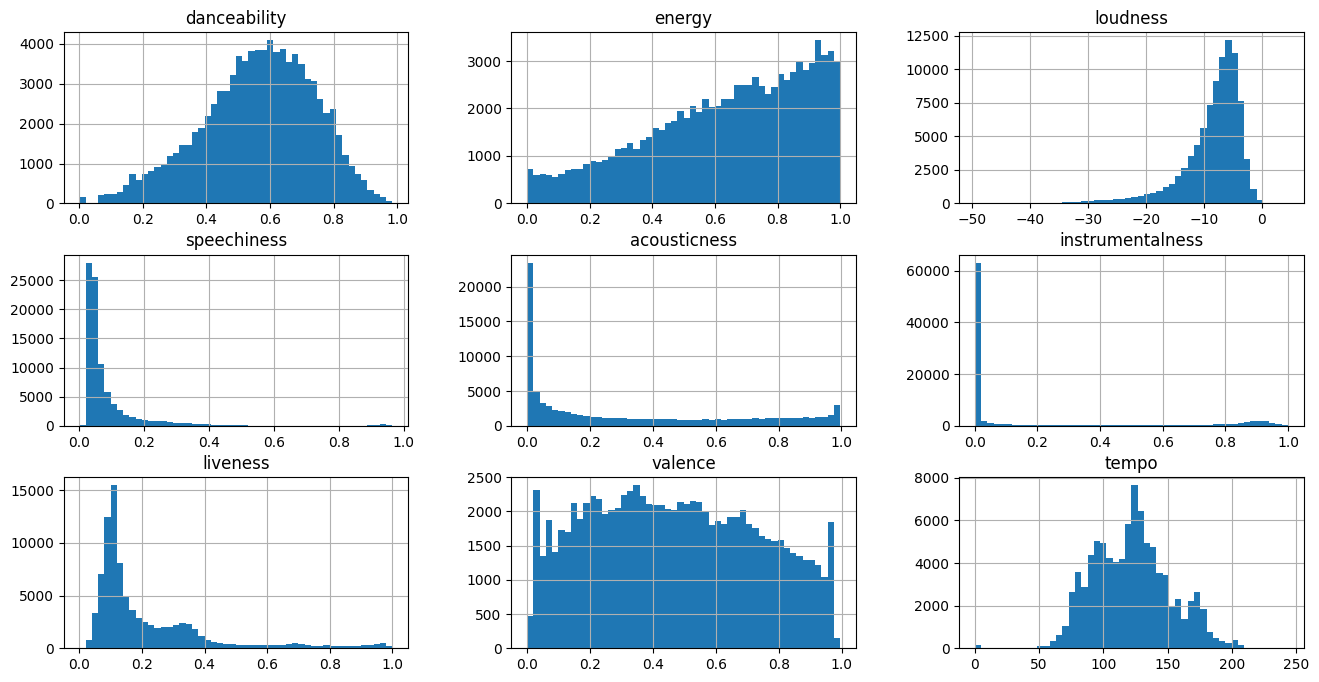

In [40]:
df[float_cols].hist(figsize=(16, 8),bins=50)
plt.show()

#### Binning

In [41]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bins = []
five_bins = []

for x in float_cols:
    range = df[x].max() - df[x].min()
    std = df[x].std()
    if x == 'speechiness':  # based on kaggle column description → 3 bins
        three_bins.append(x)
    elif range < 3 * std:
        three_bins.append(x)
    else:
        five_bins.append(x)

print("Columns with 3 bins:", three_bins)
print("Columns with 5 bins:", five_bins)

Columns with 3 bins: ['speechiness', 'acousticness']
Columns with 5 bins: ['danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'valence', 'tempo']


In [42]:
df_bins = df[['track_id']].copy()

for x in three_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=3, labels=labels_3)

for x in five_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=5, labels=labels_5)

df_bins_float = df_bins
df_bins

,track_id,speechiness_bin,acousticness_bin,danceability_bin,energy_bin,loudness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,3nqQXoyQOWXiESFLlDF1hG,Low,Low,High,Medium,High,Very Low,Low,Low,Medium
1,2tTmW7RDtMQtBk7m2rYeSw,Low,Low,High,High,Very High,Very Low,Low,Medium,Medium
2,5ww2BF9slyYgNOk37BlC4u,Low,Medium,Very High,High,Very High,Very Low,Low,Very High,Medium
3,4uUG5RXrOk84mYEfFvj3cK,Low,Low,Medium,Very High,Very High,Very Low,Low,Low,Medium
4,1IHWl5LamUGEuP4ozKQSXZ,Low,Low,High,High,Very High,Very Low,Very Low,Very Low,Medium
...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89736,4WCpgL2vHyx2vusJ5mbBnF,Low,Low,High,Very High,Very High,Very Low,Low,Medium,Medium
89737,5FImqqYMK6ZwLwClPDds8c,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89738,4BsasVXlffiJ69bRrJXWZO,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium


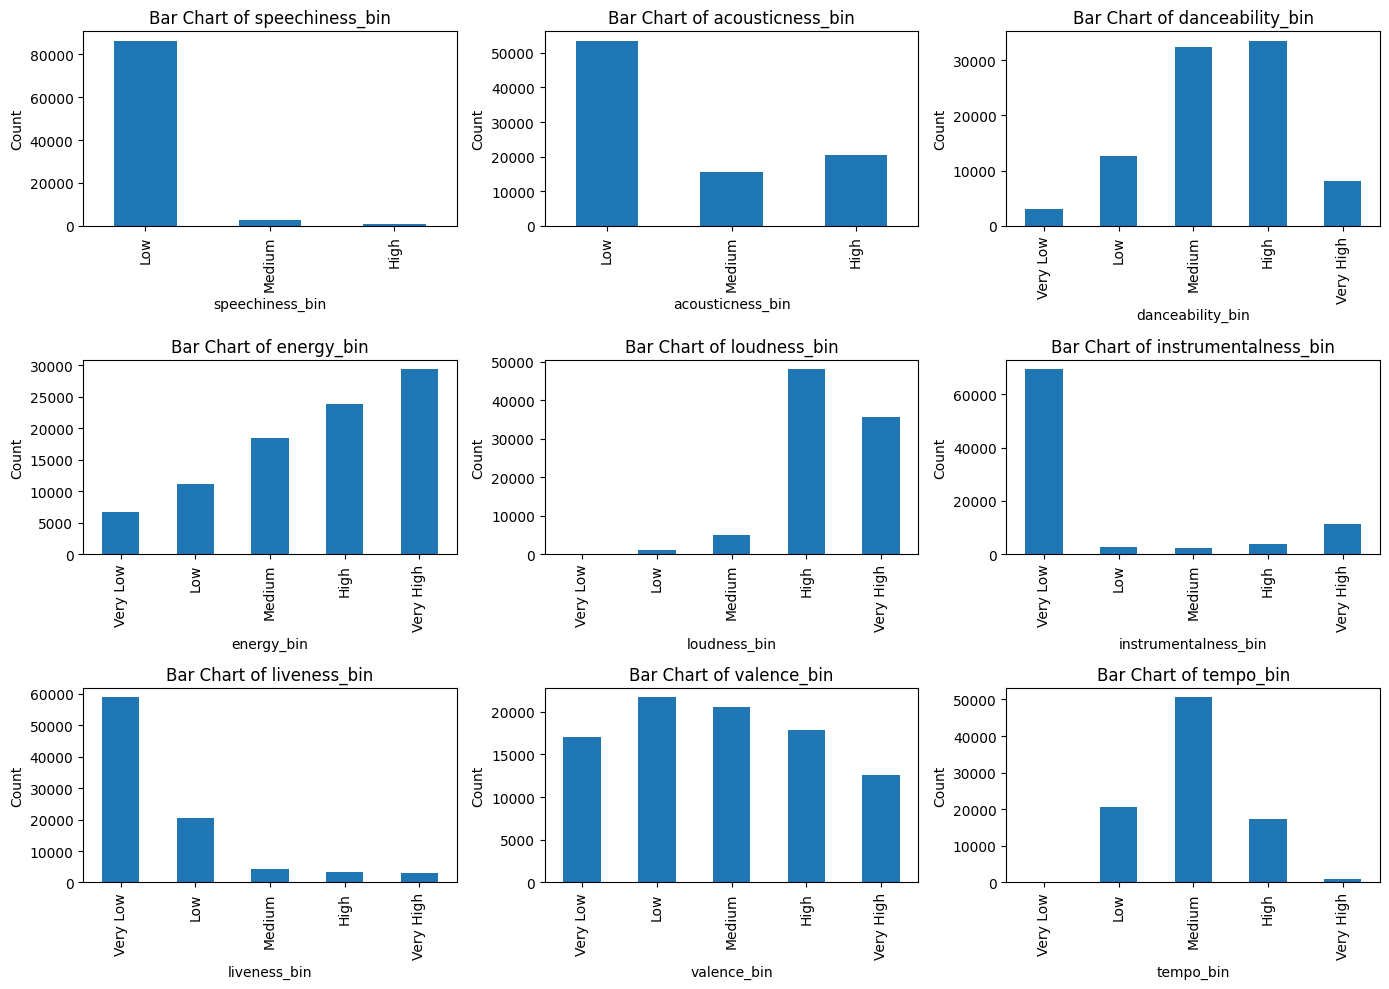

In [43]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()


#### One hot encoding

In [44]:
# one hot encode the features
df_flt_encoded = pd.get_dummies(df_bins[binned_cols])
df_flt_encoded = pd.concat([df_bins[['track_id']], df_flt_encoded], axis=1)
df_flt_encoded

,track_id,speechiness_bin_Low,speechiness_bin_Medium,speechiness_bin_High,acousticness_bin_Low,acousticness_bin_Medium,acousticness_bin_High,danceability_bin_Very Low,danceability_bin_Low,danceability_bin_Medium,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,True,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,True,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


### Merge

In [45]:
# merge binned int and float vars into one dataframe
df_merged = df_int_encoded.merge(df_flt_encoded, on='track_id', how='inner')
df_merged

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [46]:
# add 'explicit' column
df_merged = df_merged.merge(df[['track_id', 'explicit']], on='track_id', how='left')
df_merged


,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High,explicit
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [47]:

df_merged2 = df_merged.drop(columns=['track_id'])

transactions = df_merged2.apply(lambda row: list(df_merged2.columns[row.values]), axis=1).tolist()

print(transactions[:5])


[['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_High', 'energy_bin_Medium', 'loudness_bin_High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Low', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_High', 'energy_bin_High', 'loudness_bin_Very High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Medium', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Medium', 'danceability_bin_Very High', 'energy_bin_High', 'loudness_bin_Very High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Very High', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_Medium', 'energy_bin_Very High', 'loudness_bin_Very High', 'in

## Association Rule Learning

### Frequent Itemset Mining

In [48]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

Checking for ideal support threshold

In [49]:
del(range)

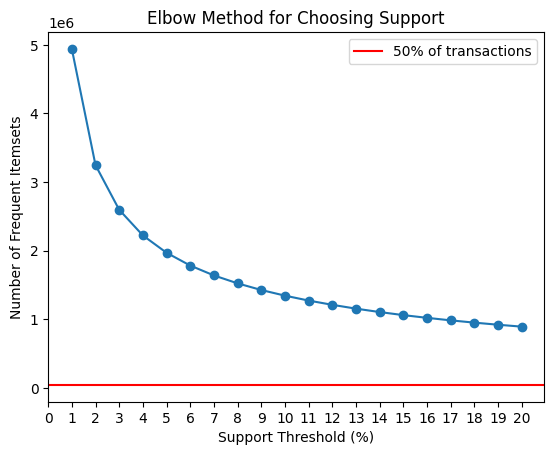

In [50]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.5, color = 'r', label = '50% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

Many patterns are very common --> added zmax = 3 to limit itemset size

In [51]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, zmax = 3, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

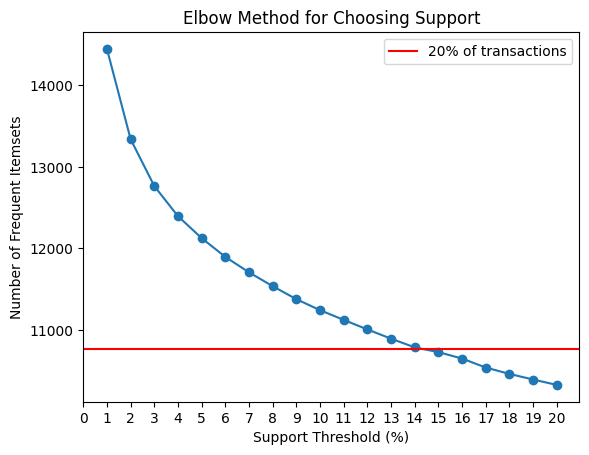

In [52]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.12, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

### Significant Itemsets

In [53]:
get_fim(-14, transactions)

,itemset,support_absolute,support_relative
0,"(duration_ms_bin_Very Low,)",89646,0.998953
2,"(speechiness_bin_Low,)",86350,0.962224
1,"(speechiness_bin_Low, duration_ms_bin_Very Low)",86262,0.961244
6,"(instrumentalness_bin_Very Low,)",69480,0.774237
3,"(instrumentalness_bin_Very Low, duration_ms_bi...",69433,0.773713
...,...,...,...
7273,"(liveness_bin_Very High, energy_bin_Low, dance...",14,0.000156
8941,"(instrumentalness_bin_Medium, danceability_bin...",14,0.000156
9131,"(loudness_bin_Low, valence_bin_Low, instrument...",14,0.000156
6387,"(liveness_bin_High, energy_bin_Low, valence_bi...",14,0.000156


In [54]:
# calculates the frequent itemset using fpgrowth algorithm
def get_sig(supp, conf, transactions):

    result = arules(transactions, supp=supp, conf=conf, zmax=3, report='asc')
    colnames = ['consequent', 'antecedent'] + ['support_absolute', 'support_relative', 'confidence_pct']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

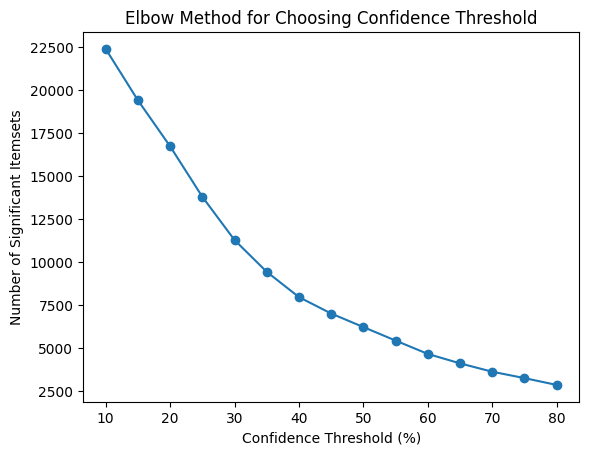

In [55]:
confidence = range(10, 81, 5)  # Test supports from 1% to 20%
num_itemsets = []

for conf in confidence:
    rules = get_sig(-14, conf, transactions)
    num_itemsets.append(len(rules))

plt.plot(confidence, num_itemsets, marker='o')
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.show()

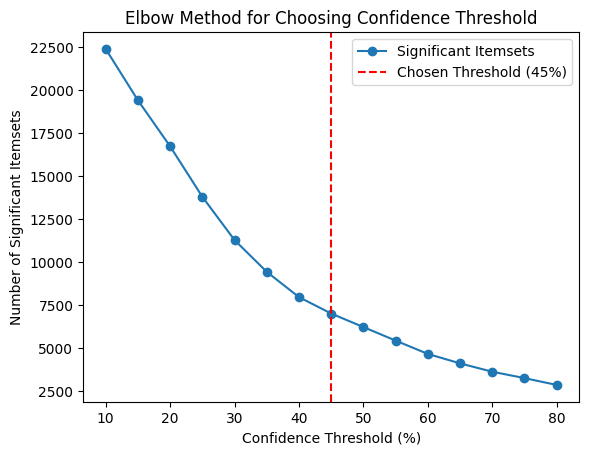

In [56]:
plt.plot(confidence, num_itemsets, marker='o', label="Significant Itemsets")
plt.axvline(x=45, color='r', linestyle='dashed', label="Chosen Threshold (45%)")
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.legend()
plt.show()


In [57]:
# focus on those where popularity appears in the consequent

rules = get_sig(-14, 45, transactions)
rules_filtered = rules[rules["consequent"].astype(str).str.contains("popularity", na=False)]
rules_filtered

,consequent,antecedent,support_absolute,support_relative,confidence_pct
2383,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2921,0.032550,0.453853
2381,popularity_bin_Very Low,"(instrumentalness_bin_Very High, acousticness_...",2864,0.031914,0.509156
2386,popularity_bin_Very Low,"(instrumentalness_bin_Very High, energy_bin_Ve...",1629,0.018152,0.529068
4677,popularity_bin_Low,"(liveness_bin_Very High,)",1478,0.016470,0.515881
4663,popularity_bin_Low,"(liveness_bin_Very High, duration_ms_bin_Very ...",1476,0.016448,0.515723
...,...,...,...,...,...
6883,popularity_bin_Low,"(duration_ms_bin_Low, acousticness_bin_Medium)",9,0.000100,0.473684
6044,popularity_bin_Very Low,"(speechiness_bin_High, energy_bin_Very Low)",9,0.000100,0.529412
5646,popularity_bin_Very Low,"(loudness_bin_Low, valence_bin_High)",9,0.000100,0.562500
6043,popularity_bin_Low,"(speechiness_bin_High, energy_bin_Very Low)",8,0.000089,0.470588


In [72]:
rules_filtered[:3]

,consequent,antecedent,support_absolute,support_relative,confidence_pct
2383,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2921,0.032550,0.453853
2381,popularity_bin_Very Low,"(instrumentalness_bin_Very High, acousticness_...",2864,0.031914,0.509156
2386,popularity_bin_Very Low,"(instrumentalness_bin_Very High, energy_bin_Ve...",1629,0.018152,0.529068


In [73]:
# to view entire antecedent since it was truncated in the dataframe

def get_antecedents(id, rules_df):

    antecedents_dict = {}

    for id in id:
          antecedents_dict[id] = rules_df.loc[id]["antecedent"]

    return antecedents_dict

id_list = [2383, 2381, 2386]
antecedents = get_antecedents(id_list, rules_filtered)

for id, antecedent in antecedents.items():
    print(f"Index {id}: {antecedent}")


Index 2383: ('instrumentalness_bin_Very High', 'tempo_bin_Medium')
Index 2381: ('instrumentalness_bin_Very High', 'acousticness_bin_Low')
Index 2386: ('instrumentalness_bin_Very High', 'energy_bin_Very High')


__Observations:__

among the top three association rules, all of which had very low popularity as the consequent, very high instrumentalness consistently appeared as an antecedent

other characteristics that frequently appeared alongside it included medium tempo, low acousticness, and very high energy

In [70]:
df_combined = pd.merge(df_bins_int[['track_id', 'popularity_bin']], df_bins_float[['track_id', 'tempo_bin', 'instrumentalness_bin', 'acousticness_bin','energy_bin']], on='track_id', how='inner')

df_combined = pd.merge(df_combined, df[['track_id','track_genre']], on='track_id', how='inner')

df_check = df_combined[df_combined["instrumentalness_bin"] == 'Very High']
print(df_check["popularity_bin"].value_counts())


popularity_bin
Very Low     4836
Low          3267
Medium       2947
High          389
Very High       4
Name: count, dtype: int64


songs with very high instrumentalness have varying popularity from very low till very high, though it is concentrated among the less popular status

In [65]:
# top genres of 1st rule

df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["tempo_bin"] == 'Medium') & (df_combined["popularity_bin"] == 'Very Low')]
print(df_check["track_genre"].value_counts().head(5))


track_genre
detroit-techno    542
idm               298
chicago-house     291
grindcore         240
iranian           217
Name: count, dtype: int64


In [66]:
# top genres of 2nd rule

df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["acousticness_bin"] == 'Low') & (df_combined["popularity_bin"] == 'Very Low')]
print(df_check["track_genre"].value_counts().head(5))

track_genre
detroit-techno    523
grindcore         360
chicago-house     297
idm               251
black-metal       179
Name: count, dtype: int64


In [69]:
# top genres of 3rd rule

df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["energy_bin"] == 'Very High') & (df_combined["popularity_bin"] == 'Very Low')]
print(df_check["track_genre"].value_counts().head(5))

track_genre
grindcore         323
detroit-techno    221
black-metal       147
chicago-house     123
drum-and-bass     119
Name: count, dtype: int64


## Writeup/Analysis

Refer to the **Requirements section** for the guide questions.

**Spotify Dataset** (Total of 55 pts.)

1. Find another dataset that can be turned into an association rule learning problem. Ideally, more than 1000 transactions/records. This does not have to be grocery-related. (20 pts)
2. Similar to the grocery dataset, calculate the association rules and find the `significant/interesting` items. (10 pts)

3. What would you recommend given the association rules? (20 pts)
  - Based on our analysis, songs that have very high instrumentalness often have lower popularity. This was a common antecedent among the top 3 rules. This does not mean, however, that these songs cannot get popular. There are songs containing this characteristic that have a very high popularity status. Looking further into the specific genres associated with the top 3 rules that have a very low popularity, it can be seen that most fall under the general category of underground EDM music, extreme metal/punk, and regional music. The characteristic of very high instrumentalness may be more common in niche genres that dont often reach the same mainstream success as other songs. These combinations of song characteristics may provide more insight to those in the music industry. Analysis of audience expectations and music trends may help influence the way music is produced whether the goal is for an artist to reach mainstream or reach stronger engagement with more niche audiences.


4. Any other learnings? (5 pts)
  - A lot of preprocessing may be needed depending on the original set of data to transform it into a form that can be used for association rule learning.
  - The context in which association rule learning is used is very important. Unlike the groceries dataset wherein the goal was more clearly defined, the spotify dataset, having a lot of features, was more open ended. It might not have been needed to include everything in the association rule learning section as it would depend on the goal of the analysis. Using only the relevant features to the research goal may also improve the effectiveness of association rule learning.
  - Correlation does not imply causality. Just like in the spotify dataset, it doesn't mean that very high instrumentalness in a song causes very low popularity. Extra analysis on the results may be done to extract useful insights

## References

- https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

## End
<sup>made by **Jude Michael Teves**</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> <href>judemichaelteves@gmail.com</href> or <href>jude.teves@dlsu.edu.ph</href></sup><br>